# Evolutionary transition rates of leaf endopolyploidy

James Seery (jseery@mail.uoguelph.ca)

## Setting up

#### Load packages and functions

In [1]:
tryCatch(    # Load corHMM package. Provides the functions for ancestral reconstruction and inference of transition rates.
    library(corHMM),
    error = install.packages("corHMM", repos = "http://cran.utstat.utoronto.ca/")
)
tryCatch(    # Load CAPER package. Provides the ability to prune a large phylogeny.
    library(caper),
    error = install.packages("caper", repos = "http://cran.utstat.utoronto.ca/")
)
#source("corHMM_functions.R")

Installing package into 'C:/Users/CCCP/Documents/R/win-library/3.2'
(as 'lib' is unspecified)


package 'corHMM' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\CCCP\AppData\Local\Temp\RtmpmO3Ybn\downloaded_packages


Loading required package: ape
Loading required package: nloptr
Loading required package: GenSA
Installing package into 'C:/Users/CCCP/Documents/R/win-library/3.2'
(as 'lib' is unspecified)


package 'caper' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\CCCP\AppData\Local\Temp\RtmpmO3Ybn\downloaded_packages


Loading required package: MASS
Loading required package: mvtnorm


#### Import data

##### Figure out what is the best indicator of endopolyploidy

In [2]:
setwd("../../Raw_data")
endo.data = read.csv("Endo_literature_data/Mined+summer_full.csv")

In [3]:
print("How many entries for leaf endoreduplication index (EI)?")
length(endo.data$EI[!is.na(endo.data$EI)])
print("How many entries for mean leaf ploidy?")
length(endo.data$Mean.ploidy[!is.na(endo.data$Mean.ploidy)])

[1] "How many entries for leaf endoreduplication index (EI)?"


[1] 243

[1] "How many entries for mean leaf ploidy?"


[1] 186

##### Make subset that only has EI.

In [4]:
endo = endo.data[, c(1,3,5)]
names(endo) = c("name", "state", "state2")
endo = subset(endo, !is.na(endo$state))

In [5]:
summary(endo$state)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.00000 0.02230 0.04516 0.17670 0.14740 2.31800 

##### Turn endopolyploidy into a character with two states

In [6]:
threshold = 0.1 # Specify threshold endoreduplication index for deciding whether a species has endopolyploid leaves.
state = numeric(length(endo$state)) + 0
state[endo$state < threshold] = 1
state[endo$state >= threshold] = 2
print("Proportion of species in state 2:")
length(state[state == 2]) / length(state)
endo$state = state

[1] "Proportion of species in state 2:"


[1] 0.3127572

##### Turn endopolyploidy and woodiness into a three-state character

In [7]:
print("These are the species that are woody endopolyploids")
endo.data$Species[endo.data$EI > 0.1 & endo.data$GH == "W"]

[1] "These are the species that are woody endopolyploids"


[1] Opuntia_tomentosa Sophora_japonica 
248 Levels: Acer_nigrum Acer_saccharinum Acer_saccharum ... Zea_mays

These species were removed from the analysis because we have too few data to estimate the transitions to the Woody+endopolyploid state

In [8]:
endo.data = subset(endo.data, endo.data$EI < 0.1 & endo.data$GH == "W" | endo.data$GH == "H")

In [9]:
state2 = numeric(length(endo$state)) + 0
state2[endo$state2 == "W"] = 1
state2[endo$state2 == "H"] = 2
state2[endo$state == 2] = 3 # Represents non-woody endopolyploidy
endo$state2 = state2

write.csv(endo, file="../state_data.csv")

#### Import entire Zanne phylogeny (phylo)

In [10]:
setwd("../../Raw_data")
phylo = read.tree("Zanne_phylo/Zanne.nwk")
phylo = makeLabel(phylo) # Add unique labels to all unnamed nodes

ERROR: Error in setwd("../../Raw_data"): cannot change working directory


#### Match the phylogeny (~30,000 species) to the dataset (~168 species)

In [11]:
data = comparative.data(phy = phylo,
                        data = endo,
                        names.col = "name")

##### Extract matched species

In [12]:
endo.matched = data.frame(data$phy$tip.label, data$data)
names(endo.matched) = c("V1", "V2", "V3")
#endo.matched$V2 = as.factor(endo.matched$V2)
rownames(endo.matched) = NULL

## Modelling evolutionary transition rates of leaf endopolyploidy

#### Symmetric transition model

In [13]:
Sym_model = rayDISC(phy = data[[1]],
                    data = endo.matched,
                    model = "ER",
                    node.state = "marginal"
                   )

Sym_model

State distribution in data:
States:	1	2	
Counts:	145	61	
Initializing... 
Finished. Beginning thorough search... 
Finished. Inferring ancestral states using marginal reconstruction. 
Finished. Performing diagnostic tests. 



Fit
      -lnL     AIC     AICc ntax
 -100.1455 202.291 202.3106  206

Rates
            1           2
1          NA 0.005582159
2 0.005582159          NA

Arrived at a reliable solution 

#### Asymmetric transition models

In [14]:
Asym_model = rayDISC(phy = data[[1]],
                    data = endo.matched,
                    model = "ARD",
                    node.state = "marginal"
                   )

Asym_model

State distribution in data:
States:	1	2	
Counts:	145	61	
Initializing... 
Finished. Beginning thorough search... 
Finished. Inferring ancestral states using marginal reconstruction. 
Finished. Performing diagnostic tests. 



Fit
      -lnL     AIC     AICc ntax
 -93.15551 190.311 190.3701  206

Rates
           1           2
1         NA 0.005611855
2 0.01798355          NA

Arrived at a reliable solution 

##### Compare models using a $\chi^2$ test of ln(likelihood) scores

In [15]:
comp.Asym.Sym = 2*(Asym_model$loglik - Sym_model$loglik) ###order of function should have the better fitting model (higher loglik) listed first
comp.Asym.Sym
pchisq(comp.Asym.Sym, df = 1, lower.tail=FALSE)

[1] 13.98001

[1] 0.0001847643

Asymmetric model is significantly better and has lowest AIC score.

## Modelling transitions of endopolyploidy and woodiness

We have at least one species that is woody and endopolyploidy. For now it has been binned into non-woody endopolyploid species.

In [16]:
Sym_wood_model = rayDISC(phy = data[[1]],
                        data = endo.matched,
                        charnum = 2, # Specifies the endo+woody trait
                        model = "ER",
                        node.state = "marginal"
                       )

Sym_wood_model

State distribution in data:
States:	1	2	3	
Counts:	52	93	61	
Initializing... 
Finished. Beginning thorough search... 
Finished. Inferring ancestral states using marginal reconstruction. 
Finished. Performing diagnostic tests. 



Fit
      -lnL     AIC     AICc ntax
 -143.1275 288.255 288.2746  206

Rates
            1           2           3
1          NA 0.004195295 0.004195295
2 0.004195295          NA 0.004195295
3 0.004195295 0.004195295          NA

Arrived at a reliable solution 

In [17]:
Asym_wood_model = rayDISC(phy = data[[1]],
                        data = endo.matched,
                        charnum = 2, # Specifies the endo+woody trait
                        model = "ARD",
                        node.state = "marginal"
                       )

Asym_wood_model

State distribution in data:
States:	1	2	3	
Counts:	52	93	61	
Initializing... 
Finished. Beginning thorough search... 
Finished. Inferring ancestral states using marginal reconstruction. 
Finished. Performing diagnostic tests. 



Fit
      -lnL      AIC     AICc ntax
 -127.8692 267.7384 268.1605  206

Rates
             1           2           3
1           NA 0.003235773 0.004727290
2 0.0006217572          NA 0.008129526
3 0.0000000000 0.018821216          NA

Arrived at a reliable solution 

##### Compare models using a $\chi^2$ test of ln(likelihood) scores

In [18]:
comp.Asym.Sym_wood = 2*(Asym_wood_model$loglik - Sym_wood_model$loglik) ###order of function should have the better fitting model (higher loglik) listed first
comp.Asym.Sym_wood
pchisq(comp.Asym.Sym_wood, df = 1, lower.tail=FALSE)

[1] 30.51667

[1] 3.310094e-08

Asymmetric model has significantly higher likelihood and lower AIC

## What rates are equal to zero?

In [77]:
trans_mat = rate.mat.maker(hrm = FALSE, ntraits = 1, nstates = 3, model = "ARD")
logliks = matrix(nrow = 6, ncol = 4)
colnames(logliks) = c("Dropped rate", "LogLik of full model", "LogLik of dropped model", "Chi square p value")
logliks[, 1] = 1:6
logliks[, 2] = rep(Asym_wood_model$loglik, 6)

trans_mats = list()
Asym_wood_model_d = list()

for(i in 1:6){
    trans_mats[[i]] = rate.par.drop(trans_mat, drop.par = i)
    
    Asym_wood_model_d[[i]] = rayDISC(phy = data[[1]],
                                     data = endo.matched,
                                     charnum = 2, # Specifies the endo+woody trait
                                     model = "ARD",
                                     node.state = "marginal",
                                     rate.mat = trans_mats[[i]]
                                     )
    
    logliks[i, 3] = Asym_wood_model_d[[i]]$loglik
    
    chisq = 2*sqrt((logliks[i, 2] - logliks[i, 3])^2) # Two times the difference 
    
    logliks[i, 4] = pchisq(chisq, df = 1, lower.tail=FALSE)
}

State distribution in data:
States:	1	2	3	
Counts:	52	93	61	
Initializing... 
Finished. Beginning thorough search... 
Finished. Inferring ancestral states using marginal reconstruction. 
Finished. Performing diagnostic tests. 
State distribution in data:
States:	1	2	3	
Counts:	52	93	61	
Initializing... 
Finished. Beginning thorough search... 
Finished. Inferring ancestral states using marginal reconstruction. 
Finished. Performing diagnostic tests. 
State distribution in data:
States:	1	2	3	
Counts:	52	93	61	
Initializing... 
Finished. Beginning thorough search... 
Finished. Inferring ancestral states using marginal reconstruction. 
Finished. Performing diagnostic tests. 
State distribution in data:
States:	1	2	3	
Counts:	52	93	61	
Initializing... 
Finished. Beginning thorough search... 
Finished. Inferring ancestral states using marginal reconstruction. 
Finished. Performing diagnostic tests. 
State distribution in data:
States:	1	2	3	
Counts:	52	93	61	
Initializing... 
Finished. Begi

### Is rate 2 equal to zero?

In [68]:
trans_mat_d2 = rate.mat.maker(hrm = FALSE, ntraits = 1, nstates = 3, model = "ARD")
trans_mat_d2 = rate.par.drop(trans_mat_d2, drop.par = 2)
trans_mat_d2

1  2  3
1 NA  3  5
2  1 NA  6
3  2  4 NA

In [20]:
Asym_wood_model_d2 = rayDISC(phy = data[[1]],
                        data = endo.matched,
                        charnum = 2, # Specifies the endo+woody trait
                        model = "ARD",
                        node.state = "marginal",
                        rate.mat = trans_mat_d2
                       )

Asym_wood_model_d2

State distribution in data:
States:	1	2	3	
Counts:	52	93	61	
Initializing... 
Finished. Beginning thorough search... 
Finished. Inferring ancestral states using marginal reconstruction. 
Finished. Performing diagnostic tests. 



Fit
      -lnL      AIC     AICc ntax
 -127.8693 265.7387 266.0387  206

Rates
             1           2           3
1           NA 0.003285668 0.004671657
2 0.0006211687          NA 0.008157419
3           NA 0.018788602          NA

Arrived at a reliable solution 

#### This model is roughly equivalent to the fully assymetric model in likelihood, but has a slightly lower AIC

###  Is rate 1 from the fully asymmetric model equal to zero?

In [67]:
trans_mat_d1 = rate.mat.maker(hrm = FALSE, ntraits = 1, nstates = 3, model = "ARD")
trans_mat_d1 = rate.par.drop(trans_mat_d1, drop.par = 1)
trans_mat_d1

1  2  3
1 NA  3  5
2  1 NA  6
3  2  4 NA

In [22]:
Asym_wood_model_d1 = rayDISC(phy = data[[1]],
                        data = endo.matched,
                        charnum = 2, # Specifies the endo+woody trait
                        model = "ARD",
                        node.state = "marginal",
                        rate.mat = trans_mat_d1
                       )

Asym_wood_model_d1

State distribution in data:
States:	1	2	3	
Counts:	52	93	61	
Initializing... 
Finished. Beginning thorough search... 
Finished. Inferring ancestral states using marginal reconstruction. 
Finished. Performing diagnostic tests. 



Fit
      -lnL      AIC     AICc ntax
 -128.1415 266.2829 266.5829  206

Rates
             1           2           3
1           NA 0.003219618 0.005028685
2           NA          NA 0.008038962
3 0.0006534279 0.018491256          NA

Arrived at a reliable solution 

#### Is this transition significantly zero?

In [23]:
comp.Asym_wood_d1 = 2*(Asym_wood_model$loglik - Asym_wood_model_d1$loglik) ###order of function should have the better fitting model (higher loglik) listed first
comp.Asym_wood_d1
pchisq(comp.Asym_wood_d1, df = 1, lower.tail=FALSE) # It might be.

[1] 0.5445826

[1] 0.4605397

### Are both rates 1 and 2 equal to zero

In [24]:
trans_mat_d12 = rate.par.drop(trans_mat_d2, drop.par = 1)
trans_mat_d12

1  2  3
1 NA  1  3
2 NA NA  4
3 NA  2 NA

In [25]:
Asym_wood_model_d12 = rayDISC(phy = data[[1]],
                        data = endo.matched,
                        charnum = 2, # Specifies the endo+woody trait
                        model = "ARD",
                        node.state = "marginal",
                        rate.mat = trans_mat_d12
                       )

Asym_wood_model_d12

State distribution in data:
States:	1	2	3	
Counts:	52	93	61	
Initializing... 
Finished. Beginning thorough search... 
Finished. Inferring ancestral states using marginal reconstruction. 
Finished. Performing diagnostic tests. 



Fit
      -lnL      AIC     AICc ntax
 -128.3204 264.6408 264.8398  206

Rates
   1           2           3
1 NA 0.003326107 0.005461657
2 NA          NA 0.007521961
3 NA 0.018603719          NA

Arrived at a reliable solution 

#### Is at least one rate significantly different from zero?

In [26]:
comp.Asym_wood_d12 = 2*(Asym_wood_model$loglik - Asym_wood_model_d12$loglik) ###order of function should have the better fitting model (higher loglik) listed first
comp.Asym_wood_d12
pchisq(comp.Asym_wood_d12, df = 1, lower.tail=FALSE) # No. Asym_wood_model_d12 also has the lowest AIC.

[1] 0.9024465

[1] 0.3421266

### Are rates 1 and 3 from the fully asymmetric model equal?

In [60]:
trans_mat_eq13 = rate.mat.maker(hrm = FALSE, ntraits = 1, nstates = 3, model = "ARD")
trans_mat_eq13 = rate.par.eq(trans_mat_eq13, eq.par = c(1,3))
trans_mat_eq13

1  2  3
1 NA  1  4
2  1 NA  5
3  2  3 NA

In [28]:
Asym_wood_model_eq13 = rayDISC(phy = data[[1]],
                        data = endo.matched,
                        charnum = 2, # Specifies the endo+woody trait
                        model = "ARD",
                        node.state = "marginal",
                        rate.mat = trans_mat_eq13
                       )

Asym_wood_model_eq13

State distribution in data:
States:	1	2	3	
Counts:	52	93	61	
Initializing... 
Finished. Beginning thorough search... 
Finished. Inferring ancestral states using marginal reconstruction. 
Finished. Performing diagnostic tests. 



Fit
      -lnL      AIC     AICc ntax
 -125.8418 261.6835 261.9835  206

Rates
           1          2           3
1         NA 0.00000000 0.000000000
2 0.00000000         NA 0.008375845
3 0.00472491 0.01507361          NA

Arrived at a reliable solution 

#### Do these rates differ significantly?

In [29]:
comp.Asym_wood_eq13 = 2*(Asym_wood_model_eq13$loglik - Asym_wood_model$loglik) ###order of function should have the better fitting model (higher loglik) listed first
comp.Asym_wood_eq13
pchisq(comp.Asym_wood_eq13, df = 1, lower.tail=FALSE)

[1] 4.054821

[1] 0.0440454

Yes.. It seems that this biologically nonsense model fits the data best

## In the fully symmetric model, are rates 2 and 5 equal?

In [61]:
trans_mat_eq25 = rate.mat.maker(hrm = FALSE, ntraits = 1, nstates = 3, model = "ARD")
trans_mat_eq25 = rate.par.eq(trans_mat_eq25, eq.par = c(2,5))
trans_mat_eq25

1  2  3
1 NA  3  2
2  1 NA  5
3  2  4 NA

In [63]:
Asym_wood_model_eq25 = rayDISC(phy = data[[1]],
                        data = endo.matched,
                        charnum = 2, # Specifies the endo+woody trait
                        model = "ARD",
                        node.state = "marginal",
                        rate.mat = trans_mat_eq25
                       )

Asym_wood_model_eq25

State distribution in data:
States:	1	2	3	
Counts:	52	93	61	
Initializing... 
Finished. Beginning thorough search... 
Finished. Inferring ancestral states using marginal reconstruction. 
Finished. Performing diagnostic tests. 



Fit
      -lnL      AIC     AICc ntax
 -128.7243 267.4485 267.7485  206

Rates
             1           2           3
1           NA 0.005617731 0.001780414
2 4.527134e-05          NA 0.010486993
3 1.780414e-03 0.018181730          NA

Arrived at a reliable solution 

#### Do these rates differ significantly?

In [64]:
comp.Asym_wood_eq25 = 2*(Asym_wood_model$loglik - Asym_wood_model_eq25$loglik) ###order of function should have the better fitting model (higher loglik) listed first
comp.Asym_wood_eq25
pchisq(comp.Asym_wood_eq25, df = 1, lower.tail=FALSE) # No

[1] 1.710166

[1] 0.1909638

### In the fully symmetric model, are rates 4 and 6 equal?

In [62]:
trans_mat_eq46 = rate.mat.maker(hrm = FALSE, ntraits = 1, nstates = 3, model = "ARD")
trans_mat_eq46 = rate.par.eq(trans_mat_eq46, eq.par = c(4,6))
trans_mat_eq46

1  2  3
1 NA  3  5
2  1 NA  4
3  2  4 NA

In [65]:
Asym_wood_model_eq46 = rayDISC(phy = data[[1]],
                        data = endo.matched,
                        charnum = 2, # Specifies the endo+woody trait
                        model = "ARD",
                        node.state = "marginal",
                        rate.mat = trans_mat_eq46
                       )

Asym_wood_model_eq46

State distribution in data:
States:	1	2	3	
Counts:	52	93	61	
Initializing... 
Finished. Beginning thorough search... 
Finished. Inferring ancestral states using marginal reconstruction. 
Finished. Performing diagnostic tests. 



Fit
      -lnL      AIC     AICc ntax
 -130.2224 270.4448 270.7448  206

Rates
             1           2            3
1           NA 0.007687389 0.0003597123
2 0.0005673316          NA 0.0123872980
3 0.0000000000 0.012387298           NA

Arrived at a reliable solution 

#### Do these rates differ significantly?

In [66]:
comp.Asym_wood_eq46 = 2*(Asym_wood_model$loglik - Asym_wood_model_eq46$loglik) ###order of function should have the better fitting model (higher loglik) listed first
comp.Asym_wood_eq46
pchisq(comp.Asym_wood_eq46, df = 1, lower.tail=FALSE) # Yes

[1] 4.706444

[1] 0.03004975

### Plot best model

#### Woodiness and endopolyploidy transition model where transitions are asymmetric and rates 1 and 2 are equal to zero

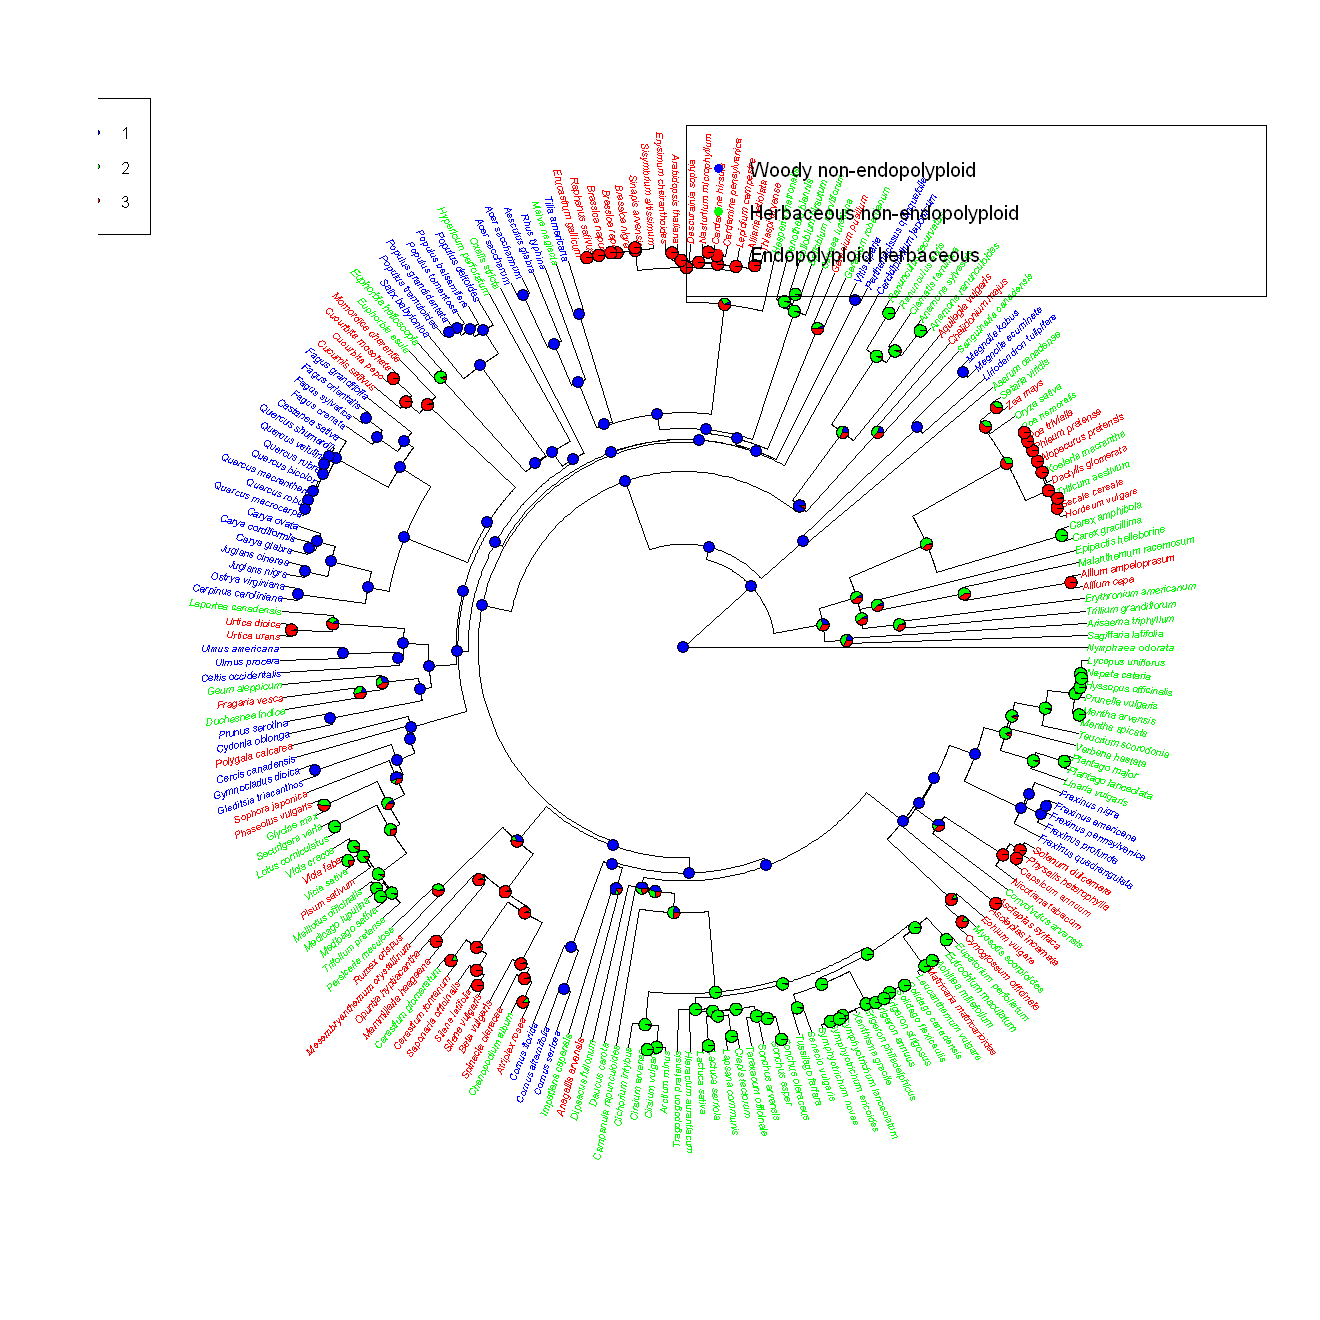

In [56]:
col = c("blue", "green", "red")
tip.cols = endo$state2[pmatch(data$phy$tip.label, endo$name, nomatch = 0)] # Matches name of tip to the dataset and returns the state of the tip
plotRECON(phy = data[[1]],
          type = "fan",
          Asym_wood_model_d12$states,
          #file = "Asym_wood_model_d12",
          piecolors=col, 
          tip.color = col[tip.cols]
         )
options(repr.plot.width=11, repr.plot.height=11)
legend("topright",
       inset = 0.025, 
       c("Woody non-endopolyploid", "Herbaceous non-endopolyploid", "Endopolyploid herbaceous"),
       col = col,
       pch = 16)